In [1]:
import xgboost
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'  # 모든 텍스트 요소에 대해 굵은 글씨 적용
plt.rcParams['axes.labelweight'] = 'bold'  # 축 라벨에 대해 굵은 글씨 적용
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.utils import resample
import pickle

In [2]:
path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis again'
X = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis.xlsx')
y = X['30_days_label']

drop_list = ['30_days_label']
X = X.drop(drop_list, axis=1)

fea_list = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/feature_list thesis.xlsx')
nominal_fea = fea_list[fea_list['Nominal']==1]['Type_Short_Name'].tolist()
nominal_fea = list(set(nominal_fea) & set(X.columns))
X = pd.get_dummies(X, columns=nominal_fea, drop_first=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# 모델 훈련 및 저장 함수
def train_and_save_model(model, model_name, X_train, y_train, path):
    model.fit(X_train, y_train)
    pickle.dump(model, open(os.path.join(path, f"{model_name}.pickle.dat"), "wb"))

In [4]:
# 모델 구성 및 훈련
models = {
    "XGBoost": xgboost.XGBClassifier(
        learning_rate=0.05,
        n_estimators=200,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.7,
    ),    
     "Deep Neural Network": MLPClassifier(
        alpha=0.0001,                     # L2 규제 항
        batch_size=128,                   # 배치 크기
        hidden_layer_sizes=(100,), # 은닉층 크기 및 층 수
        learning_rate_init=0.01,         # 학습률 초기값
        max_iter=1000,                   # 최대 반복 횟수
        solver='adam',                   # 솔버
        random_state=7                   # 결과의 재현성을 위한 랜덤 상태
    ),   
"Logistic Regression": LogisticRegression(
    C=0.001,
    penalty='l2',  # 'l2' 패널티 유지
    solver='saga',  # 'saga' 솔버 사용
    max_iter=10000,  
)
}

In [5]:
for name, model in models.items():
    train_and_save_model(model, name, X_train, y_train, path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis again/XGBoost.pickle.dat'

NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

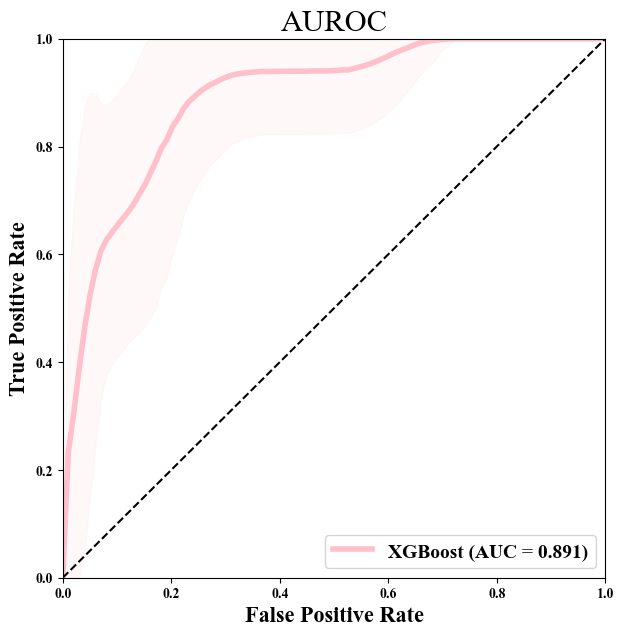

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
import pickle
import os

def plot_roc_pr_curves_with_confidence_intervals(models, X_test, y_test, n_bootstraps=1000, alpha=0.05):
    rng = np.random.RandomState(seed=42)  # For reproducibility
    
    plt.figure(figsize=(7, 7))

        
    # 모델별로 다른 색상 지정
    colors = {
        "XGBoost": "#FFC0CB",
        "Deep Neural Network": "#A2CFFE",
        "Logistic Regression": "#BDA0CB"
    }
    linewidth = 12  # 선의 굵기
    fontsize_ticks = 16  # x축과 y축의 틱 라벨 크기
    
    for model_name, model in models.items():
        bootstrapped_tpr = []
        bootstrapped_precision = []
        bootstrapped_recall = []
    
        mean_fpr = np.linspace(0, 1, 100)  # 고정된 간격으로 평균 FPR 값 설정
        mean_recall = np.linspace(0, 1, 100)  # 고정된 간격으로 평균 Recall 값 설정

        
        # 부트스트랩 반복
        for i in range(n_bootstraps):
            indices = rng.randint(0, len(y_test), len(y_test))
            if len(np.unique(y_test.iloc[indices])) < 2:
                continue  # 샘플에 하나의 클래스만 있는 경우 건너뜁니다.
            
            y_true_sampled = y_test.iloc[indices]
            y_pred_sampled = model.predict_proba(X_test.iloc[indices])[:, 1]

            # ROC 커브 계산
            fpr, tpr, _ = roc_curve(y_true_sampled, y_pred_sampled)
            tpr_interpolated = np.interp(mean_fpr, fpr, tpr)
            tpr_interpolated[0] = 0.0  # 시작점을 0으로 설정
            bootstrapped_tpr.append(tpr_interpolated)
            
            # PR 커브 계산
            precision, recall, _ = precision_recall_curve(y_true_sampled, y_pred_sampled)
            precision_interpolated = np.interp(mean_recall, recall[::-1], precision[::-1])
            bootstrapped_precision.append(precision_interpolated)
            bootstrapped_recall.append(mean_recall)

        # TPR과 Precision의 평균과 표준편차 계산
        bootstrapped_tpr = np.array(bootstrapped_tpr)
        tpr_mean = bootstrapped_tpr.mean(axis=0)
        tpr_std = bootstrapped_tpr.std(axis=0)
        
        bootstrapped_precision = np.array(bootstrapped_precision)
        precision_mean = bootstrapped_precision.mean(axis=0)
        precision_std = bootstrapped_precision.std(axis=0)

        # 95% 신뢰 구간 계산
        tpr_upper = np.minimum(tpr_mean + 2 * tpr_std, 1)
        tpr_lower = np.maximum(tpr_mean - 2 * tpr_std, 0)
        precision_upper = np.minimum(precision_mean + 2 * precision_std, 1)
        precision_lower = np.maximum(precision_mean - 2 * precision_std, 0)

                # 모델 이름에 따라 색상을 지정
        model_color = colors.get(model_name, "black")  # 모델 이름에 해당하는 색상이 없으면 기본값으로 "black" 사용

        # ROC 커브 그리기
        line, = plt.plot(mean_fpr, tpr_mean, label=f'{model_name} (AUC = {auc(mean_fpr, tpr_mean):.3f})', color=model_color, linewidth=4)
        plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color=line.get_color(), alpha=0.1)  # line.get_color() 사용
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('AUROC', fontsize=22)
        plt.legend(loc="lower right", fontsize=14)
    


plot_roc_pr_curves_with_confidence_intervals(models, X_test, y_test)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/AUROC plot.tiff', format='tiff', dpi=300)

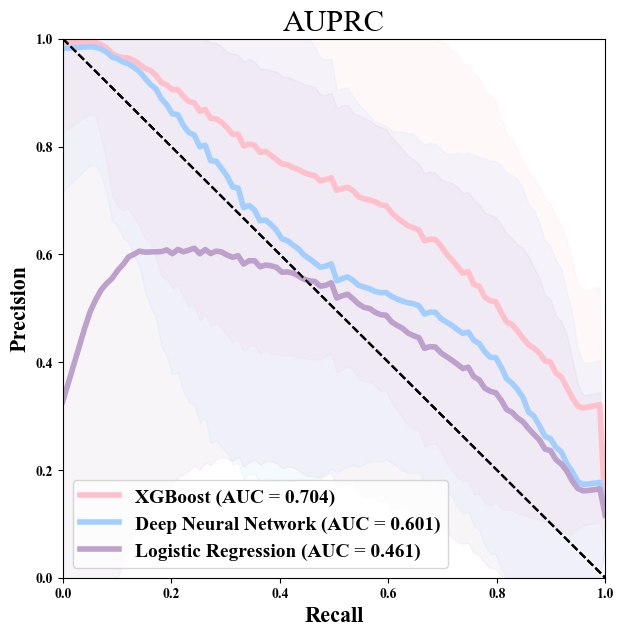

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
import pickle
import os

def plot_roc_pr_curves_with_confidence_intervals(models, X_test, y_test, n_bootstraps=1000, alpha=0.05):
    rng = np.random.RandomState(seed=42)  # For reproducibility
    
    plt.figure(figsize=(7, 7))

        
    # 모델별로 다른 색상 지정
    colors = {
        "XGBoost": "#FFC0CB",
        "Deep Neural Network": "#A2CFFE",
        "Logistic Regression": "#BDA0CB"
    }
    linewidth = 6  # 선의 굵기
    fontsize_ticks = 16  # x축과 y축의 틱 라벨 크기
    
    for model_name, model in models.items():
        bootstrapped_tpr = []
        bootstrapped_precision = []
        bootstrapped_recall = []
    
        mean_fpr = np.linspace(0, 1, 100)  # 고정된 간격으로 평균 FPR 값 설정
        mean_recall = np.linspace(0, 1, 100)  # 고정된 간격으로 평균 Recall 값 설정

        
        # 부트스트랩 반복
        for i in range(n_bootstraps):
            indices = rng.randint(0, len(y_test), len(y_test))
            if len(np.unique(y_test.iloc[indices])) < 2:
                continue  # 샘플에 하나의 클래스만 있는 경우 건너뜁니다.
            
            y_true_sampled = y_test.iloc[indices]
            y_pred_sampled = model.predict_proba(X_test.iloc[indices])[:, 1]

                        # ROC 커브 계산
            fpr, tpr, _ = roc_curve(y_true_sampled, y_pred_sampled)
            tpr_interpolated = np.interp(mean_fpr, fpr, tpr)
            tpr_interpolated[0] = 0.0  # 시작점을 0으로 설정
            bootstrapped_tpr.append(tpr_interpolated)

            # PR 커브 계산
            precision, recall, _ = precision_recall_curve(y_true_sampled, y_pred_sampled)
            precision_interpolated = np.interp(mean_recall, recall[::-1], precision[::-1])
            bootstrapped_precision.append(precision_interpolated)
            bootstrapped_recall.append(mean_recall)

        # TPR과 Precision의 평균과 표준편차 계산
        bootstrapped_tpr = np.array(bootstrapped_tpr)
        tpr_mean = bootstrapped_tpr.mean(axis=0)
        tpr_std = bootstrapped_tpr.std(axis=0)
        
        bootstrapped_precision = np.array(bootstrapped_precision)
        precision_mean = bootstrapped_precision.mean(axis=0)
        precision_std = bootstrapped_precision.std(axis=0)

        # 95% 신뢰 구간 계산
        tpr_upper = np.minimum(tpr_mean + 2 * tpr_std, 1)
        tpr_lower = np.maximum(tpr_mean - 2 * tpr_std, 0)
        precision_upper = np.minimum(precision_mean + 2 * precision_std, 1)
        precision_lower = np.maximum(precision_mean - 2 * precision_std, 0)

                        # 모델 이름에 따라 색상을 지정
        model_color = colors.get(model_name, "black")  # 모델 이름에 해당하는 색상이 없으면 기본값으로 "black" 사용

        # PR 커브 그리기
        pr_auc = auc(mean_recall, precision_mean)  # PR AUC 계산
        line, = plt.plot(mean_recall, precision_mean, label=f'{model_name} (AUC = {pr_auc:.3f})',  color=model_color, linewidth=4)
        plt.fill_between(mean_recall, precision_lower, precision_upper, color=line.get_color(), alpha=0.1)  # line.get_color() 사용
        plt.plot([0, 1], [1, 0], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall', fontsize=16)
        plt.ylabel('Precision', fontsize=16)
        plt.title('AUPRC', fontsize=22)
        plt.legend(loc="lower left", fontsize=14)

plot_roc_pr_curves_with_confidence_intervals(models, X_test, y_test)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/AUPRC plot.tiff', format='tiff', dpi=300)

In [13]:
def calculate_p_value(models, X_test, y_test, n_bootstraps=1000, seed=42, metric='auroc'):
    rng = np.random.RandomState(seed)
    wins = {name: 0 for name in models if name != 'XGBoost'}  # XGBoost와 비교하여 다른 모델들의 승리 횟수

    for i in range(n_bootstraps):
        # 부트스트랩 샘플 생성
        indices = rng.randint(0, len(y_test), size=len(y_test))
        
        # Pandas DataFrame/Series 또는 Numpy 배열 여부에 따라 적절한 인덱싱
        if isinstance(X_test, pd.DataFrame):
            X_boot = X_test.iloc[indices]
            y_boot = y_test.iloc[indices] if isinstance(y_test, pd.Series) else y_test[indices]
        else:
            X_boot = X_test[indices]
            y_boot = y_test[indices]

        # 각 모델의 성능 계산
        performances = {}
        for name, model in models.items():
            y_pred_proba = model.predict_proba(X_boot)[:, 1]
            if metric == 'auroc':
                performances[name] = roc_auc_score(y_boot, y_pred_proba)
            elif metric == 'auprc':
                precision, recall, _ = precision_recall_curve(y_boot, y_pred_proba)
                performances[name] = auc(recall, precision)

        # XGBoost와 다른 모델들 간 성능 비교
        xgb_performance = performances['XGBoost']
        for name, performance in performances.items():
            if name != 'XGBoost' and performance >= xgb_performance:
                wins[name] += 1

    # p-value 계산
    p_values = {name: wins[name] / n_bootstraps for name in wins}
    return p_values

def print_p_values(p_values, precision=6):
    """p-value 딕셔너리를 주어진 정밀도로 출력합니다."""
    for name, p_value in p_values.items():
        print(f"{name}: {p_value:.{precision}f}")

# 모델 성능 평가 및 p-value 계산
p_values_auroc = calculate_p_value(models, X_test, y_test, metric='auroc')
p_values_auprc = calculate_p_value(models, X_test, y_test, metric='auprc')

print("AUROC p-values:")
print_p_values(p_values_auroc)
print("\nAUPRC p-values:")
print_p_values(p_values_auprc)

AUROC p-values:
Deep Neural Network: 0.085000
Logistic Regression: 0.011000

AUPRC p-values:
Deep Neural Network: 0.094000
Logistic Regression: 0.013000
